# From linear regression to AR(p)

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

The purpose of this notebook is to show a simple way to go from linear models
for i.i.d. data with scikit-learn to **time series forecasting**.

The idea is to use a **temporal embedding** of the delayed time series
with a **Hankel matrix**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hankel

p = 3
x = np.arange(1, 7)
x

array([1, 2, 3, 4, 5, 6])

In [6]:
X = hankel(x, r=np.zeros(p))
X

array([[1., 2., 3.],
       [2., 3., 4.],
       [3., 4., 5.],
       [4., 5., 6.],
       [5., 6., 0.],
       [6., 0., 0.]])

We have our features $X$, now we need the target variable $y$:

*Note:* We work so that the number of samples is kept constant.
It's a hard constraint of scikit-learn that any transformation
to data keeps the number of samples fixed.

In [7]:
y = np.roll(x, -p)
y

array([4, 5, 6, 1, 2, 3])

In [8]:
X[-p:] = 0.
y[-p:] = 0.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
def forecast(model, x, n_samples):
    order = model.coef_.size  # order is p (ie the number of past samples used)
    y_pred = np.empty(n_samples + order)  # the prediction
    y_pred[:order] = x[-order:]
    for i in range(n_samples):  # now predict one sample at a time
        y_pred[i + order] = model.predict(y_pred[i:i + order][None, :])
    return y_pred[order:]

In [43]:
x_forecast = forecast(model, x, 10)
x_forecast

array([0.00645271, 0.01834669, 0.03412085, 0.05186167, 0.06952971,
       0.08518936, 0.09721643, 0.10446172, 0.10635482, 0.10293953])

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Take $x_t = \sin(t/3)$ and see with which order $p$ you can forecast such a time series. You will code it and an plot the forecast</li>
      <li>Compare your result with the AutoReg model from statsmodels package.
    </ul>
    
    __Bonus:__ how does this change to predict $x_t = \sin(t / 3) + \cos(t/5)$?
</div>

Solution is in: `solutions/00a-AR_sinusoid.py`

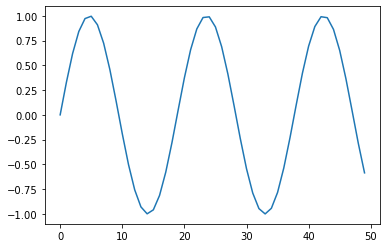

In [44]:
t = np.arange(100) / 3
x_past = np.sin(t[:50])
plt.plot(x_past)

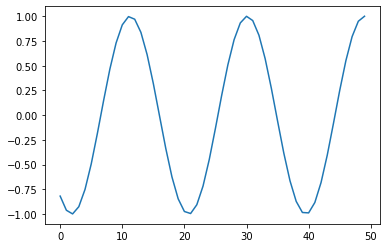

In [45]:
p = 3
x = x_past
y = np.roll(x_past, -p)

X = hankel(x, r=np.zeros(p))
X[-p:] = 0.
y[-p:] = 0.

model = LinearRegression()
model.fit(X, y)

x_forecast = forecast(model, x_past, 50)
plt.plot(x_forecast)

[Text(0.5, 1.0, 'x forecast (statsmodels)')]

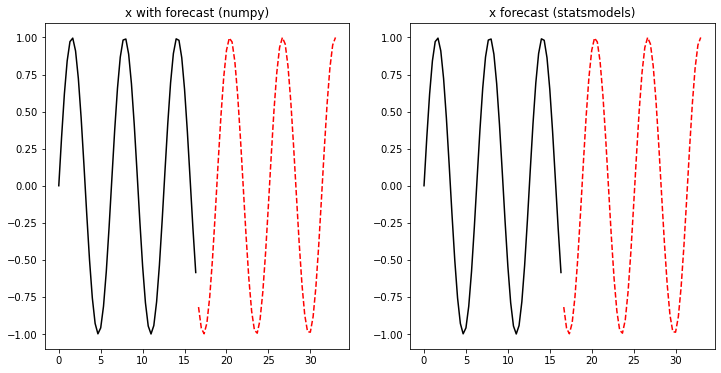

In [46]:
# %load solutions/00a-AR_sinusoid.py

p = 2
X = hankel(x_past, r=np.zeros(p))
y = np.roll(x_past, -p)
X[-p:] = 0.
y[-p:] = 0.
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
x_forecast = forecast(model, x_past, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(t[:50], x_past, 'k')
ax1.plot(t[50:], x_forecast, 'r', linestyle="--")
ax1.set(title="x with forecast (numpy)")

from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(x_past, lags=np.arange(1, p+1)).fit()
x_forecast = ar_model.predict(start=len(x_past), end=2*len(x_past) - 1)
ax2.plot(t[:50], x_past, 'k')
ax2.plot(t[50:], x_forecast, 'r', linestyle="--")
ax2.set(title="x forecast (statsmodels)")


# Evaluating a timeseries model

Let's take an example of some financial quotes

In [33]:
from utils import fetch_quote_data
quotes = fetch_quote_data(['TOT', 'XOM', 'CVX', 'COP', 'VLO'])

Loaded the quotes for ['TOT', 'XOM', 'CVX', 'COP', 'VLO']


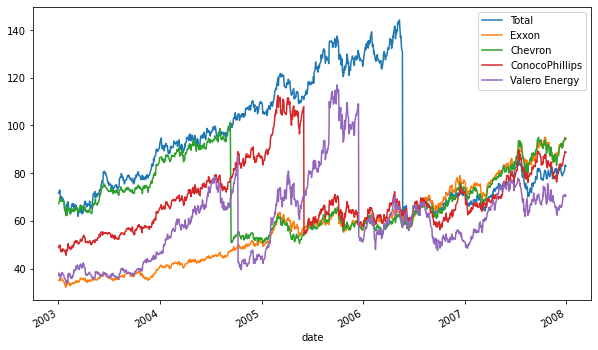

In [34]:
_, ax = plt.subplots(figsize=(10, 6))
_ = quotes.plot(ax=ax)

Let's assume we want to predict the stock price of "Chevron" from the stock price of the other companies at each time point.

In [35]:
quotes

,Total,Exxon,Chevron,ConocoPhillips,Valero Energy
date,,,,,
2003-01-02,71.62,35.00,67.20,48.80,37.04
2003-01-03,72.12,35.25,67.82,49.53,38.13
2003-01-06,72.93,35.45,68.34,49.50,37.37
2003-01-07,72.40,36.05,69.75,49.85,37.46
2003-01-08,69.51,35.15,68.46,48.44,36.51
...,...,...,...,...,...
2007-12-24,80.55,93.51,93.63,87.02,70.42
2007-12-26,81.10,93.66,94.31,87.68,70.92
2007-12-27,82.35,94.94,94.80,88.92,71.10


In [49]:
from sklearn.ensemble import GradientBoostingRegressor

X, y = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
regressor = GradientBoostingRegressor()

In [50]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=30)
scores = cross_val_score(regressor, X, y, cv=cv)
print(f'Mean R2: {scores.mean():.2f}')

Mean R2: 0.96


<div class="alert alert-success">

**QUESTION:**

- It seems that we have the perfect regressor. Is this normal? You will use the function `statsmodels.tsa.stattools.acf` look at the correlation between sucessive samples.
- Did we break any assumption of the cross-validation procedure?

</div>

Solution is in: `solutions/00b-time_series_split.py`

Mean R2: -10.20


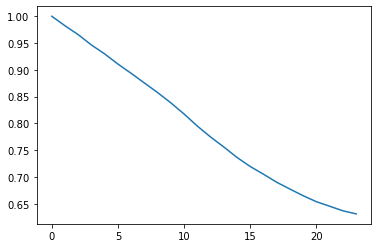

In [51]:
# %load solutions/00b-time_series_split.py

from statsmodels.tsa.stattools import acf
cor = acf(y["2007"])
plt.plot(cor)

from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(regressor, X, y, cv=cv)
print(f'Mean R2: {scores.mean():.2f}')


Let's check the different type of cross-validation that are available in scikit-learn:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py